# Game recommender
---

In [1]:
# Import modules
import numpy as np
import pandas as pd

games_df = pd.read_csv('datasets/Games_dataset.csv', index_col=0)

print('Number of games loaded: %s ' % (len(games_df)), '\n')

# Display the data
games_df.head()

Number of games loaded: 787  



,Title,Link,Genre,Developer,Publisher,Released in: Japan,North America,Rest of countries,Plots
0,1-2-Switch,/wiki/1-2-Switch,Party,Nintendo EPD,Nintendo,"March 3, 2017","March 3, 2017","March 3, 2017",1-2-Switch is a party game in which players d...
1,140,/wiki/140_(video_game),Action,Carlsen Games,Carlsen Games,Unreleased,"January 9, 2020","January 9, 2020","As described by Carlsen, 140 is “an old schoo..."
3,198X,/wiki/198X,Arcade,Hi-Bit Studios,JP,"January 23, 2020","January 23, 2020","January 23, 2020",In an introductory sequence entitled Beating ...
5,20XX,/wiki/20XX_(video_game),Platformer,Batterystaple Games,Batterystaple Games,"July 10, 2018","July 10, 2018","July 10, 2018","Inspired by Mega Man X, players must shoot or..."
6,6180 the moon,/wiki/6180_the_moon,Platformer,Turtle Cream,Turtle Cream,"June 21, 2018","May 24, 2018","May 31, 2018","In 6180 the moon, the player controls the Moo..."


In [2]:
import nltk
import re
from nltk.stem.snowball import SnowballStemmer
#nltk.download('punkt')

# Create an English language SnowballStemmer object
stemmer = SnowballStemmer("english")

# Define a function to perform both stemming and tokenization
def tokenize_and_stem(text):
    
    # Tokenize by sentence, then by word
    tokens = [word for sent in nltk.sent_tokenize(text) 
              for word in nltk.word_tokenize(sent)]
    
    # Filter out raw tokens to remove noise
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    
    # Stem the filtered_tokens
    stems = [stemmer.stem(word) for word in filtered_tokens]
    
    return stems

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate TfidfVectorizer object with stopwords and tokenizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem,
                                 ngram_range=(1,3))

# Fit and transform the tfidf_vectorizer
tfidf_matrix = tfidf_vectorizer.fit_transform([x for x in games_df["Plots"]])

tfidf_matrix.shape

/Users/hramirez/Library/Python/3.7/lib/python/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(787, 76)

In [4]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=7)

# Fit the k-means object with tfidf_matrix
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

games_df["cluster"] = clusters
games_df['cluster'].value_counts() 

5    186
4    172
2    119
1    101
6     84
3     76
0     49
Name: cluster, dtype: int64

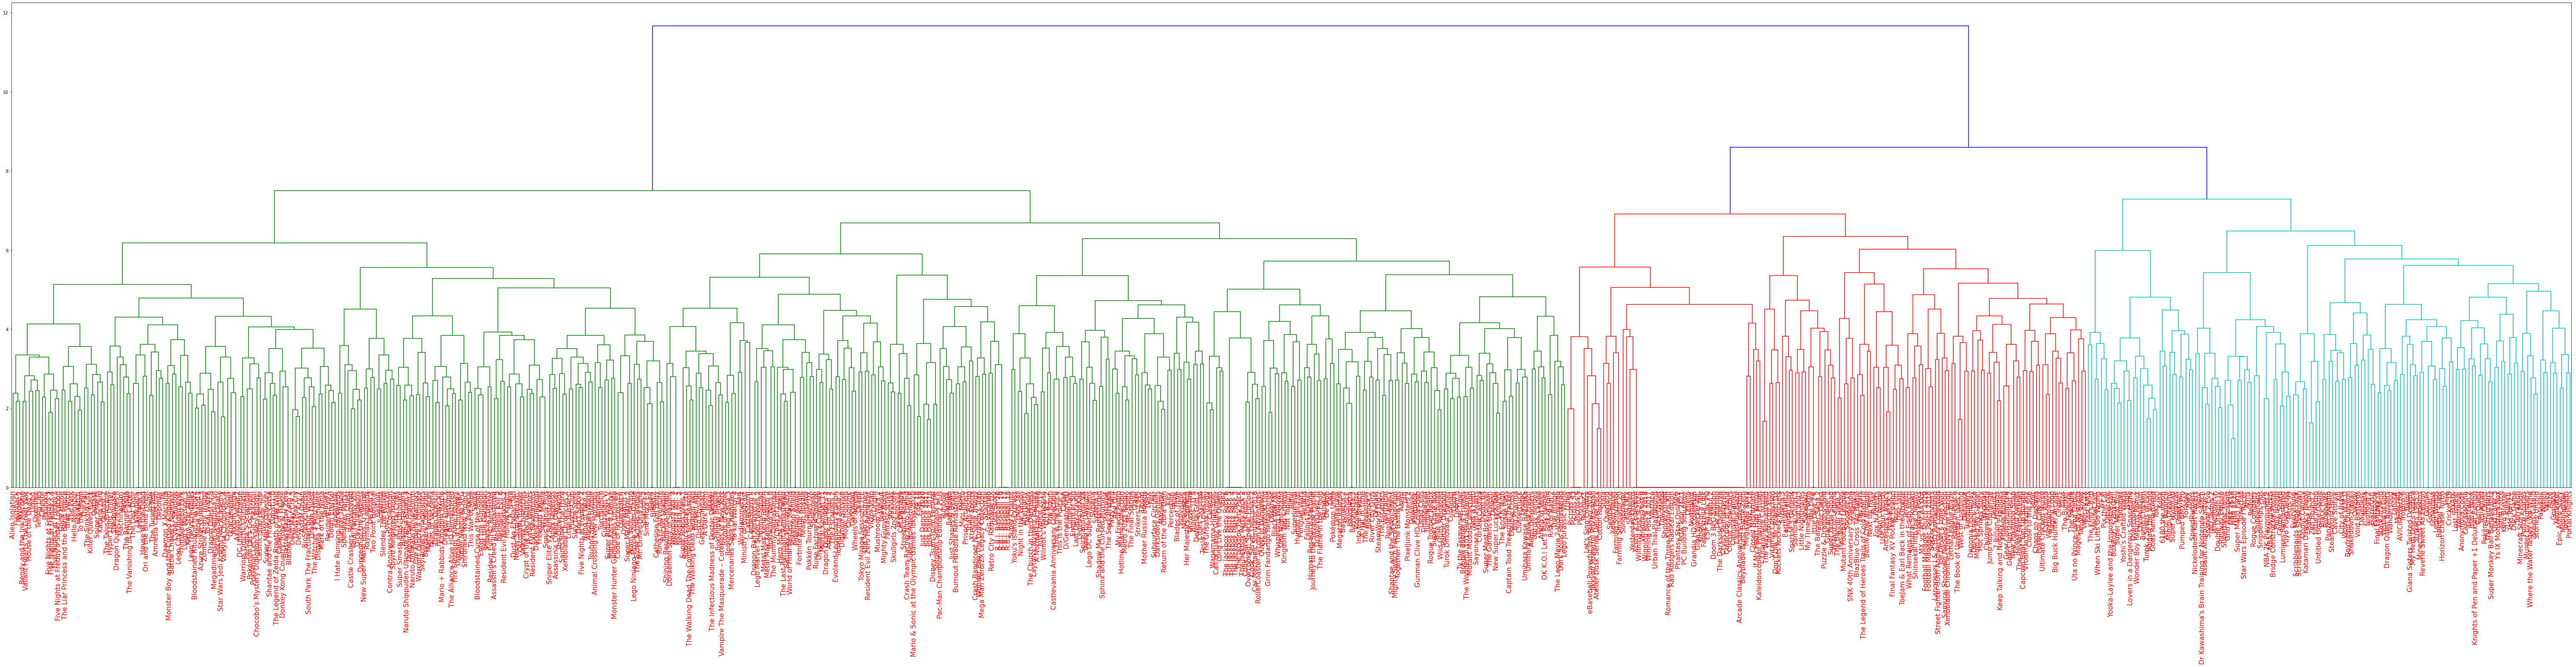

In [5]:
# Import matplotlib.pyplot for plotting graphs
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
%matplotlib inline

# Calculate the similarity distance
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

# Create mergings matrix 
mergings = linkage(similarity_distance, method='complete')

# Plot the dendrogram, using title as label column
dendrogram_ = dendrogram(mergings,
               labels=[x for x in games_df["Title"]],
               leaf_rotation=90,
               leaf_font_size=16,
)

# Adjust the plot
fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(108, 21)

plt.savefig('dendo.png', dpi=100)
plt.show()

In [6]:
# Create a DF from the similarity matrix to export
vals = games_df.Title.tolist()
similarity_df = pd.DataFrame(similarity_distance, columns=vals, index=vals)

# Export
similarity_df.to_csv('datasets/sim_matrix.csv')
similarity_df.head()

,1-2-Switch,140,198X,20XX,6180 the moon,7 Billion Humans,99Vidas,Aaero,Abzû,Aegis Defenders,...,Yo-kai Watch 4,Yoku's Island Express,Yooka-Laylee,Yooka-Laylee and the Impossible Lair,Yoshi's Crafted World,Ys IX Monstrum Nox,Ys Origin,Zen Bound 2,Ziggurat,Zombie Army Trilogy
1-2-Switch,-4.440892e-16,9.259034e-01,7.456401e-01,0.825352,0.894331,0.933194,0.745619,0.573335,0.862605,0.854316,...,0.840760,0.712352,0.675346,0.747930,0.653907,0.769732,0.902854,0.934501,0.871556,0.731851
140,9.259034e-01,-2.220446e-16,8.507763e-01,0.607665,0.717563,0.812774,0.806727,0.566813,0.856522,0.688996,...,0.785583,0.845339,0.695005,0.636247,0.549721,0.711395,0.783204,0.659413,0.809360,0.762577
198X,7.456401e-01,8.507763e-01,-2.220446e-16,0.912250,0.834952,0.932136,0.756154,0.793836,0.886516,0.887350,...,0.892285,0.728616,0.696658,0.842438,0.819185,0.808651,0.680992,0.942557,0.962559,0.457133
20XX,8.253523e-01,6.076645e-01,9.122496e-01,0.000000,0.665995,0.664245,0.749762,0.760563,0.862612,0.494424,...,0.835070,0.943332,0.603484,0.588609,0.563519,0.965476,0.801366,0.802289,0.552081,0.774128
6180 the moon,8.943315e-01,7.175627e-01,8.349522e-01,0.665995,0.000000,0.794738,0.927316,0.853534,0.916519,0.676015,...,0.929987,0.838431,0.735368,0.561154,0.682417,0.925554,0.972961,0.790702,0.681823,0.806275


In [8]:
# Recommendation example
title = 'New Super Mario Bros. U Deluxe'

matches = similarity_df[title].sort_values()[1:6]
matches = matches.index.tolist()
games_df.set_index('Title').loc[matches]

,Link,Genre,Developer,Publisher,Released in: Japan,North America,Rest of countries,Plots,cluster
Title,,,,,,,,,
Yoshi's Crafted World,/wiki/Yoshi%27s_Crafted_World,Platformer,Good-Feel,Nintendo,"March 29, 2019","March 29, 2019","March 29, 2019",The game is a side-scrolling platformer where...,6
Splatoon 2,/wiki/Splatoon_2,Third-person shooter,Nintendo EPD,Nintendo,"July 21, 2017","July 21, 2017","July 21, 2017","Like its predecessor, Splatoon 2 is a third-p...",3
Rocket League,/wiki/Rocket_League,Sports,Psyonix,Psyonix,"November 14, 2017","November 14, 2017","November 14, 2017",Rocket League's gameplay is largely the same ...,3
Lovers in a Dangerous Spacetime,/wiki/Lovers_in_a_Dangerous_Spacetime,Adventure,Asteroid Base,Asteroid Base,"October 5, 2017","October 3, 2017","October 3, 2017",The game can be played alone or with two to f...,6
Ty the Tasmanian Tiger,/wiki/Ty_the_Tasmanian_Tiger,Platform,Krome Studios,EA Games,Unreleased,"March 31, 2020","March 31, 2020",Ty the Tasmanian Tiger is a platform game in ...,6
